# **Business Problem**

This dataset is a large-scale dataset for segmentation and classification tasks. **This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey for a university-industry collaboration project at Izmir University of Economics, and this work was published in ASYU 2020. The dataset includes gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples.** This dataset was collected in order to carry out segmentation, feature extraction, and classification tasks and compare the common segmentation, feature extraction, and classification algorithms (Semantic Segmentation, Convolutional Neural Networks, Bag of Features). The dataset contains 9 different seafood types. For each class, there are 1000 augmented images and their pair-wise augmented ground truths. Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".

Click on the link to get more detailed information about the dataset: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset/data

# **Data Understanding**

First, let's bring the libraries we need and perform our import operations.

In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=4cb1bfb9ea68dd32c400080aaad22c539363b91b9ebf5dcdb03569490ce294ae
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
# Libraries to be used in reading and processing data
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# It is used to turn off warnings.
import warnings
warnings.filterwarnings('ignore')

# Libraries to be used for model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Libraries to be used for the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

Let's find the subfolders in the specified directory and return them as a list. Thus, we get the classes.

In [3]:
dir_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(dir_path) if '.' not in i]                    
classes # = folder names

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

Now, let's browse the **'dir_path'** directory and find files with the **'.png'** extension and add the path information and the class label information of each image to a data frame.

In [4]:
target_size = (224, 224)
label = []
path = []

for dir_name, _,filenames in os.walk(dir_path):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

Now that we have our data frame, let's try to understand our data by performing various examinations on it.

In [5]:
df.describe

<bound method NDFrame.describe of                                                    path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream

[9000 rows x 2 columns]>

In [6]:
print(f"The dataset contains a total of {df.shape[0]} samples and {df.shape[1]} features.")

The dataset contains a total of 9000 samples and 2 features.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [8]:
label_class_rates = 100*df["label"].value_counts()/len(df)
print("Ratios of Classes : ", label_class_rates)

Ratios of Classes :  label
Hourse Mackerel       11.111111
Black Sea Sprat       11.111111
Sea Bass              11.111111
Red Mullet            11.111111
Trout                 11.111111
Striped Red Mullet    11.111111
Shrimp                11.111111
Gilt-Head Bream       11.111111
Red Sea Bream         11.111111
Name: count, dtype: float64


object


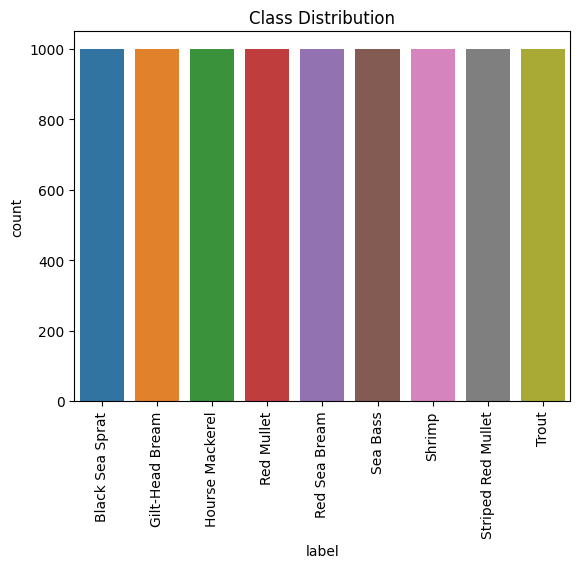

In [9]:
print(df['label'].dtype)

df['label'] = df['label'].astype('category')

sns.countplot(x=df['label'])
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


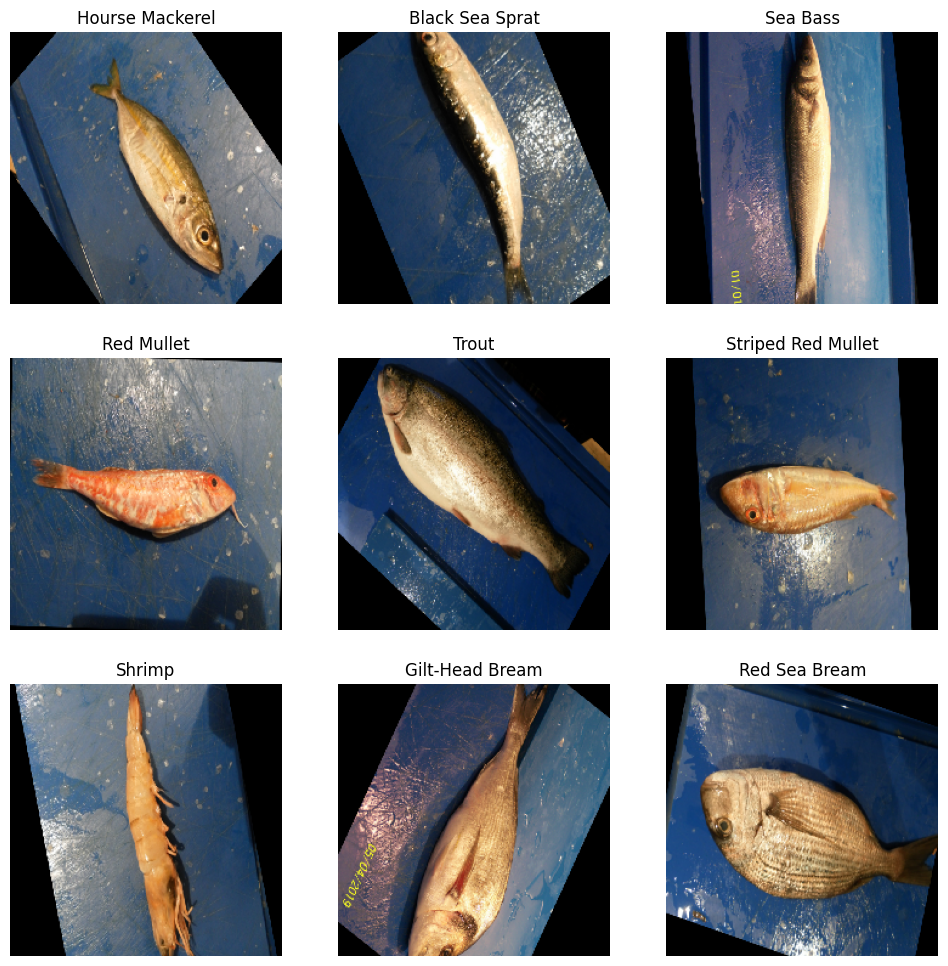

In [10]:
# Let's view an example from each class
plt.figure(figsize=(12,12))
for i, label in enumerate(df['label'].unique()[:9]): # Examples for the first 9 grades
    sample_path = df[df['label'] == label]['path'].values[0]
    img = load_img(sample_path, target_size=target_size)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()


Let's analyze the distribution of images in the dataset by checking the image dimensions. Here, let's examine the dimensions of the first 100 images (height, width and number of channels), get a statistical summary of these dimensions and create a scatter plot.

       Height  Width  Channels
count   100.0  100.0     100.0
mean    445.0  590.0       3.0
std       0.0    0.0       0.0
min     445.0  590.0       3.0
25%     445.0  590.0       3.0
50%     445.0  590.0       3.0
75%     445.0  590.0       3.0
max     445.0  590.0       3.0


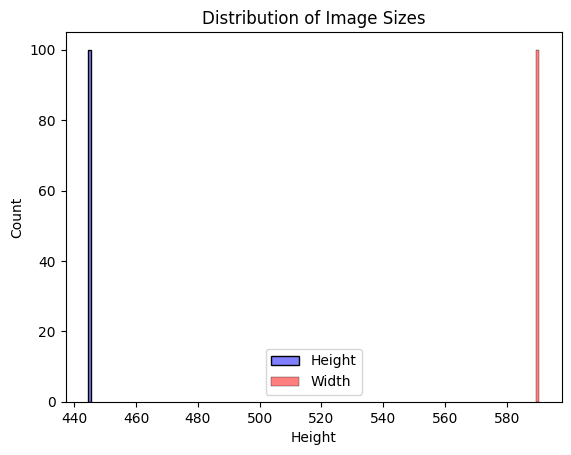

In [11]:
# Let's check the image dimensions
image_shapes = []
for img_path in df['path'].values[:100]:  # Let's check the dimensions of the first 100 images
    img = cv2.imread(img_path)
    image_shapes.append(img.shape)

# To see size distribution
image_shapes_df = pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Channels'])
print(image_shapes_df.describe())
sns.histplot(image_shapes_df['Height'], color='blue', label='Height', kde=True)
sns.histplot(image_shapes_df['Width'], color='red', label='Width', kde=True)
plt.legend()
plt.title('Distribution of Image Sizes')
plt.show()


As you can see, the dimensions of the images are quite consistent.

In [12]:
print(df.isnull().sum()) # Are there any missing values?

path     0
label    0
dtype: int64


Now let's find out what range the pixel values ​​of the image are in. Examining the pixel values ​​is important for the correct application of normalization and preprocessing steps.

In [13]:
# Let's examine the pixel values of a few sample images.
img_path = df['path'].values[0]
img = load_img(img_path, target_size=target_size)
img_array = img_to_array(img)

print("Pixel value range of sample image:", img_array.min(), "-", img_array.max())


Pixel value range of sample image: 0.0 - 255.0


# **Data Preparation**

In [14]:
# --------------- INFORMATION ------------------------
    # We will perform data augmentation. The task of the 'ImageDataGenerator'
    # function is to generate data. It performs real-time data diversification.
    # It provides the ability to create a rich, diverse set of images from a
    # small set of images for image classification and object detection. It is
    # performed using techniques such as cropping, filling, rotation and adding
    # noise. Thus, the amount of data is increased. Prevents overfitting of the
    # model.

# We define a generator for the train data set.
train = ImageDataGenerator(rescale=1./255, # Rescaling factor // images are converted between 0 and 1.
                          validation_split=0.1,# is the ratio of the test data set.
                          shear_range = 0.1, # curves the shape of the image.
                          zoom_range = 0.1,
                          brightness_range=[0.8, 1.2],
                          width_shift_range = 0.1, # Performs width shifting.
                          height_shift_range = 0.1) # performs vertical scrolling.

# We define a generator for the test data set.
test = ImageDataGenerator(rescale=1/255,
                          validation_split = 0.1)

In [15]:
train_generator = train.flow_from_directory(directory=dir_path, # the directory where our dataset is located.
                                            target_size=target_size,
                                            batch_size=32,  # size of data sets.
                                            class_mode='categorical',
                                            subset='training')

test_generator = test.flow_from_directory(directory=dir_path,
                                          target_size=target_size,
                                          batch_size=32, # size of data sets.
                                          class_mode='categorical',
                                          subset='validation')

Found 16200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [16]:
class_indices = train_generator.class_indices
class_dict = {v: k for k, v in class_indices.items()}
print(class_dict)


{0: 'Black Sea Sprat', 1: 'Gilt-Head Bream', 2: 'Hourse Mackerel', 3: 'Red Mullet', 4: 'Red Sea Bream', 5: 'Sea Bass', 6: 'Shrimp', 7: 'Striped Red Mullet', 8: 'Trout'}


# **Modeling**

In [17]:
# We determine the number of classes.
num_classes = len(classes)

# ANN Model
model = Sequential()

# Layer that converts images to vectors (flattening)
model.add(Flatten(input_shape=(224, 224, 3)))

# First Hidden Layer
model.add(Dense(1024, activation='relu')) # 1024 neuronous
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Hidden Layer
model.add(Dense(512, activation='relu')) # 512 neuronous
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Third Hidden Layer
model.add(Dense(256, activation='relu')) # 256 neuronous
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Fourth Hidden Layer
model.add(Dense(128, activation='relu')) # 128 neuronous
model.add(BatchNormalization())

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Model Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [18]:
model.summary() # Model Summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,839,561 (590.67 MB)

 Trainable params: 154,835,721 (590.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [19]:
# Callback functions to train the model (EarlyStopping ve ModelCheckpoint)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

In [20]:
# Model Training
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=50,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/50


I0000 00:00:1729709768.633788     132 service.cc:145] XLA service 0x7d1b44016630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729709768.633864     132 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/507 ━━━━━━━━━━━━━━━━━━━━ 2:14:12 16s/step - accuracy: 0.1250 - loss: 2.9921 - precision: 0.1111 - recall: 0.0312

I0000 00:00:1729709774.957126     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


507/507 ━━━━━━━━━━━━━━━━━━━━ 398s 755ms/step - accuracy: 0.2785 - loss: 1.9705 - precision: 0.3792 - recall: 0.0899 - val_accuracy: 0.2794 - val_loss: 1.9252 - val_precision: 0.3178 - val_recall: 0.1100
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 275s 535ms/step - accuracy: 0.3973 - loss: 1.5442 - precision: 0.5399 - recall: 0.1594 - val_accuracy: 0.4233 - val_loss: 1.7086 - val_precision: 0.5250 - val_recall: 0.3039
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 268s 521ms/step - accuracy: 0.4494 - loss: 1.4431 - precision: 0.5980 - recall: 0.2133 - val_accuracy: 0.3922 - val_loss: 1.9736 - val_precision: 0.4375 - val_recall: 0.3189
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 277s 539ms/step - accuracy: 0.4667 - loss: 1.3826 - precision: 0.6197 - recall: 0.2551 - val_accuracy: 0.5511 - val_loss: 1.3044 - val_precision: 0.6546 - val_recall: 0.4222
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 276s 537ms/step - accuracy: 0.4859 - loss: 1.3242 - precision: 0.6318 - recall: 0.2802 - val_accuracy: 0.5556 - val

# **Evaluation**

In [21]:
# Evaluating the performance of the model after training
score = model.evaluate(test_generator)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 295ms/step - accuracy: 0.7902 - loss: 0.6162 - precision: 0.8281 - recall: 0.7565
Test Loss: 0.6332570314407349
Test Accuracy: 0.7950000166893005


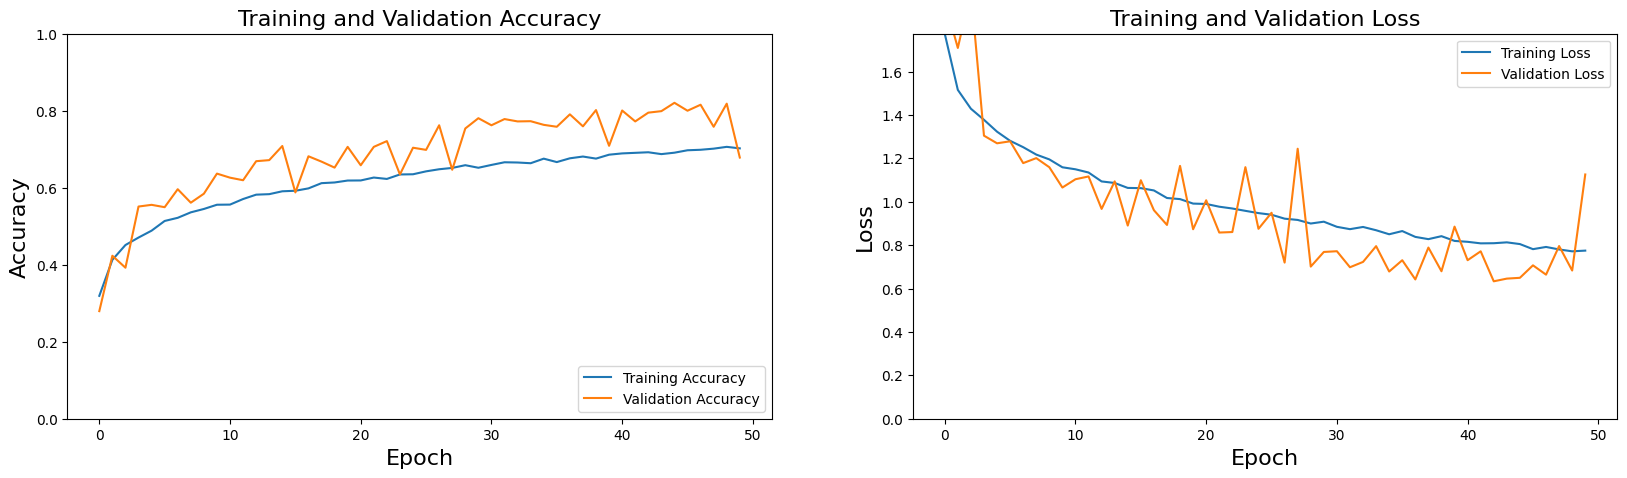

In [22]:
# ---------------------
# Accuracy Graph
# ---------------------
plt.figure(figsize=(20, 5))

# We plot the training and validation accuracy.
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy', fontsize=16)

# ---------------------
# Loss Graph
# ---------------------

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(history.history['loss'])])
plt.title('Training and Validation Loss', fontsize=16)

plt.show()